### MSI and Sentiment Bias relationship

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import matplotlib 

np.random.seed(123459)

In [2]:
# Data with only columns of interest
data = pd.read_csv('Data/dataEchoChambers_with_article_info.csv')
data['fecha'] = pd.to_datetime(data['fecha'])
data.head(n = 5)

,fecha,url_expanded,medio,opinion_dinamic,tw_id,usr_id,hora,titulo,pos_ff,neg_ff,...,T3,T4,T5,T6,T7,T8,T9,month,week,day
0,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346910135377920,716295311342321665,02:02:20,"Cristina y sus hijos, a juicio por lavar dine...",0,0,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1
1,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101346845589233665,271519704,02:02:04,"Cristina y sus hijos, a juicio por lavar dine...",0,0,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1
2,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350580142903296,987494618156675072,02:16:55,"Cristina y sus hijos, a juicio por lavar dine...",0,0,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1
3,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101350441126936580,770375532,02:16:21,"Cristina y sus hijos, a juicio por lavar dine...",0,0,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1
4,2019-03-01,https://www.clarin.com/politica/cristina-hijos...,Clarin,NaN,1101353444135370754,740350122974937088,02:28:17,"Cristina y sus hijos, a juicio por lavar dine...",0,0,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1


#### MSI of media outlets

In [3]:
score_media = pd.read_csv('Results/MSI_media.csv')
score_media

,media,msi
0,Clarin,0.609662
1,La Nacion,0.531288
2,Pagina 12,-1.362640
3,Todo Noticias,0.641982
4,Infobae,0.398505
5,El Destape,-1.495940
6,Ambito Financiero,-0.558733
7,Minuto Uno,-1.291278
8,Perfil,-0.050700
9,El Cronista,0.115708


#### Calculation of the sentiment bias

In [4]:
# Drop duplicates articles due to user behaviour in social media
data.drop_duplicates(subset=['url_expanded'], inplace=True)

In [5]:
# Sentiment bias definition
def SentimentBias(x):
    ans = (x['pos_mp'] - x['neg_mp']) - (x['pos_ff'] - x['neg_ff'])
    norm = x['N_ff'] + x['N_mp']
    if norm != 0:
        ans /= norm
        return ans 
    else:
        return np.nan

In [6]:
data['SB'] = data.apply(lambda x: SentimentBias(x), axis = 1)

#### Average sentiment bias 

In [7]:
SB_media = data.groupby('medio')['SB'].mean().sort_values().reset_index()

Merge data with the Media Sharing Index:

In [8]:
SB_media = SB_media[SB_media.medio.isin(score_media['media'])].copy()
SB_media = SB_media.merge(score_media, left_on='medio', right_on='media')[['media', 'SB', 'msi']]
SB_media

,media,SB,msi
0,Pagina 12,-0.177909,-1.362640
1,El Destape,-0.137041,-1.495940
2,Minuto Uno,-0.132435,-1.291278
3,Ambito Financiero,-0.053359,-0.558733
4,El Cronista,-0.035990,0.115708
5,Perfil,-0.026082,-0.050700
6,El Dia,-0.016239,0.309684
7,Infobae,-0.005642,0.398505
8,Todo Noticias,0.011048,0.641982
9,Clarin,0.014082,0.609662


#### Spearman correlation

In [9]:
from scipy.stats import spearmanr

print(spearmanr(SB_media['SB'], SB_media['msi']))

SignificanceResult(statistic=0.9580419580419581, pvalue=9.5435818268384e-07)


#### SB and MSI figure

In [10]:
# First component of PCA just to color media outlets points
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
pca = PCA(n_components=2)

X_std = std.fit_transform(SB_media[['SB', 'msi']].to_numpy())
pca_position = pca.fit_transform(X_std)[:,0]

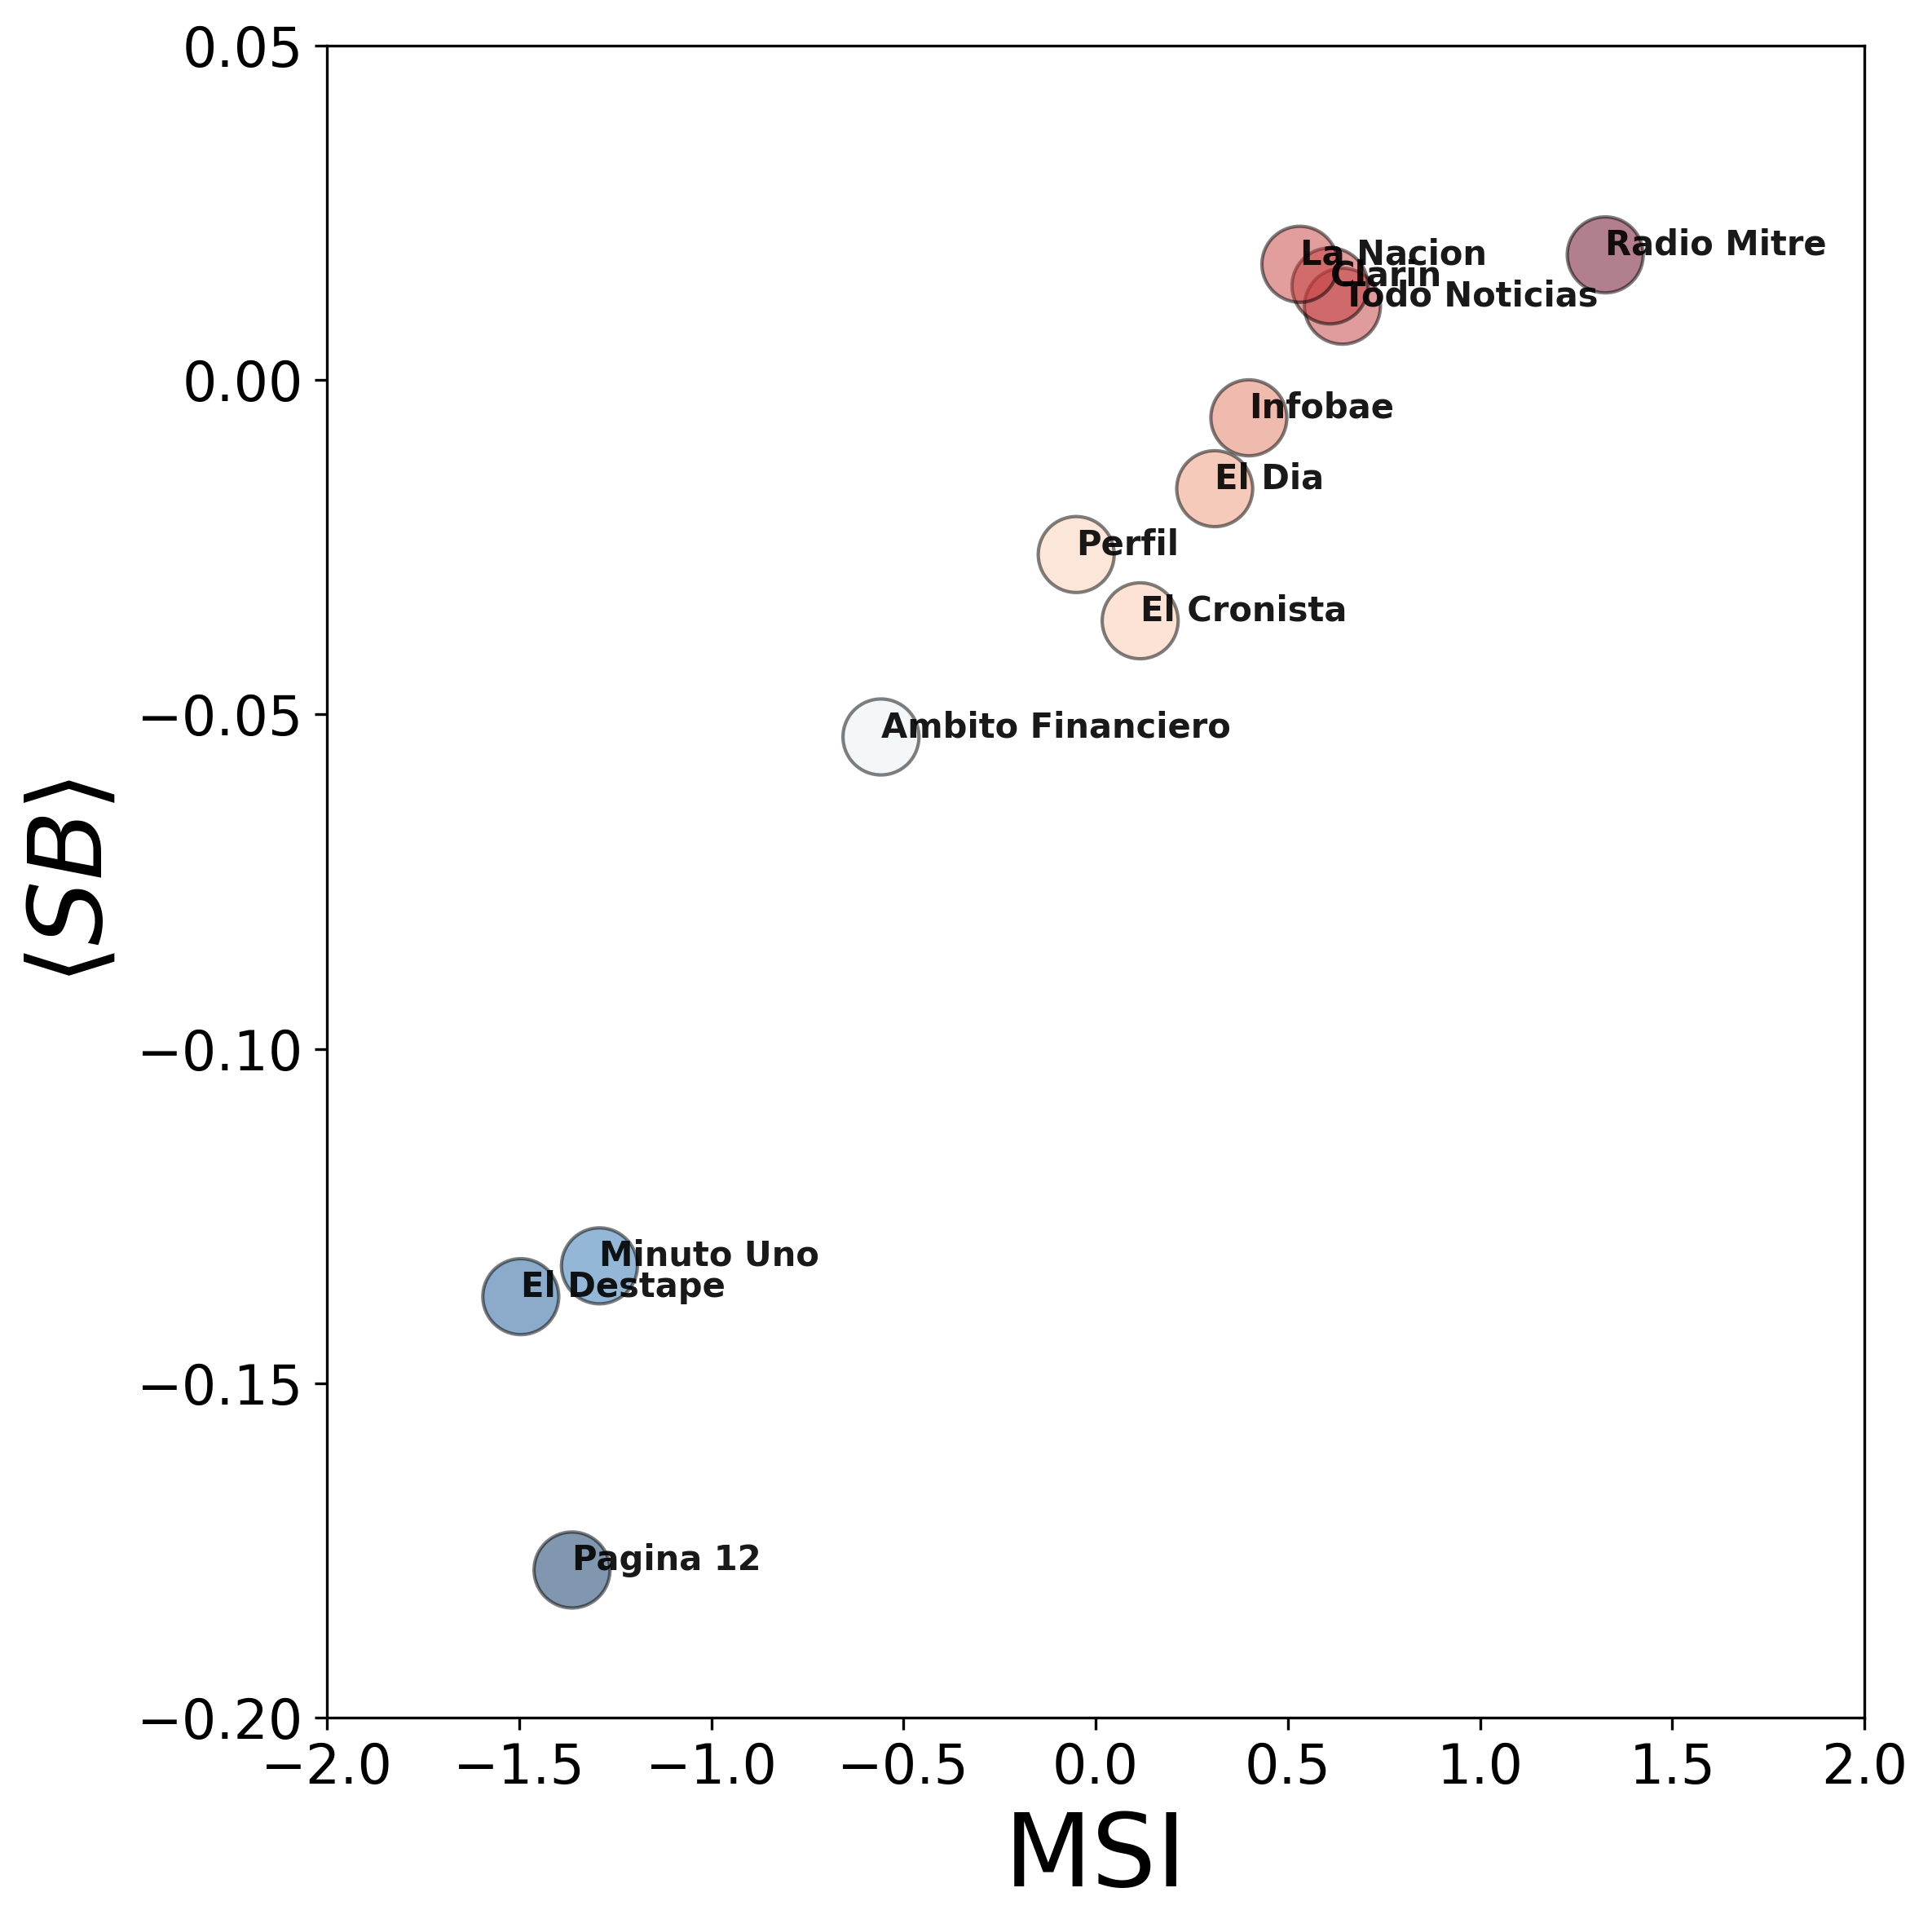

In [11]:
# SB and MSI figure
fig, ax = plt.subplots(dpi = 300, figsize=(8,8))

ax.scatter(SB_media['msi'], SB_media['SB'], alpha = 0.50, c = pca_position, cmap = 'RdBu', s = 500, edgecolors='k')

for i in range(SB_media.shape[0]):
    ax.text(SB_media.iloc[i]['msi'], SB_media.iloc[i]['SB'], SB_media.iloc[i]['media'], size = 10, fontweight = 'bold', alpha = 0.90)
    
ax.set_xlim([-2, 2])
ax.set_ylim(-0.20, 0.05)
ax.set_xlabel(r'MSI', size = 30)
ax.set_ylabel(r'$\langle SB \rangle$', size = 30)
ax.tick_params(axis='both', labelsize = 16)

fig.tight_layout()

plt.savefig('Results/MSI_SB.pdf')
plt.savefig('Results/MSI_SB.png')

plt.show()